# NeuralForceField with AuTopology priors

#### Here we show how to run NeuralForceField with classical fixed priors, and also learnable classical priors based on AuTopology.

We start off with imports:

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader


from nff.data import Dataset, split_train_validation_test
from nff.nn.modules import GraphDis
import pickle
from nff.data.loader import collate_dicts


from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
from plotting.utils import make_plot
import json
import pdb
import copy


The dataset we use below was generated in `data/create_dataset_from_file` in the usual way, but with a query ofn the database to generate the bond list, and an additional call to the command `generate_topologies()`.

In [2]:
dataset = Dataset.from_file("data/autopology_demonstration.pth.tar")

Below we'll want to compare many different targets and results, so we'll define a function `plot_overall` that plots energies and gradients vs. targets:

In [3]:
def plot_overall(results, targets):
    key_pairs = [["energy_0", "energy_0_grad"], ["energy_1", "energy_1_grad"]]
    make_plot(key_pairs, results, targets)


Clean out any old work and split the data into testing and training:

In [4]:
DEVICE = 2
OUTDIR = './sandbox'
BATCH_SIZE = 25
N_EPOCHS = 800

if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)


train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

Create the model by setting the SchNet readout dictionary, and some other parameters related to the model. Note that if `trainable_prior` is True then the constants in the classical priors are functions of the atomic environment and can be learned. Otherwise they are set to a reasonable default value and not learned.

In [5]:
# number of features in the autopology feature vector
n_autopology_features = 256

autopology_params = {
    
    "n_features": n_autopology_features,
    "n_convolutions": 4,
    "conv_type": "double_node", # this type of convolution is a concatenation of features from
                                # both the node and the nodes it's bonded to. Another option is
                                # single_node, which doesn't use a concatenation

    
    # layers applied to the features after aggregating features of bonded nodes.
    # note that the first layer has 2*256 input features because here features are concatenated
    # after a convolution. If we'd used "conv_type" = "single_node" then the first layer
    # would have to have 256 input features
        
    "conv_update_layers": [{'name': 'linear', 'param' : {'in_features': int(2*n_autopology_features),
                                                    'out_features': n_autopology_features}},
                      {'name': 'Tanh', 'param': {}},
                      {'name': 'linear', 'param' : {'in_features': n_autopology_features,
                                              'out_features': n_autopology_features}},
                      {'name': 'Tanh', 'param': {}}


            ],
    
    
    "readout_hidden_nodes": [40, 20], # the number of nodes in each of the hidden layers 
                                      # of the readout network. The readout network acts on
                                      # the features after they have been convolved.
    
    # types of classical priors to use
    "bond_terms": ["morse"],
    "angle_terms": ["harmonic"],
    "dihedral_terms": ["OPLS"],
    "improper_terms": ["harmonic"],
    "pair_terms": [], # Lennard-Jones seems to be unstable, so leave out pairs for now
    
    
    # keys we're outputting 
    "output_keys": ["energy_0", "energy_1"],
    # whether we want the AuTopology weights to be learned
    "trainable_prior": True


}


n_atom_basis = 256

readoutdict = {
                    "energy_0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}],
                    "energy_1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}]
                }


schnet_params = {
    'n_atom_basis': n_atom_basis,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True,
    'readoutdict': readoutdict,    


}


# the combined set of parameters

params = {
    
    "autopology_params": autopology_params,
    "schnet_params": schnet_params,
    # output keys in order of ascending energy:
    "sorted_result_keys": ["energy_0", "energy_1"],
    "grad_keys": ["energy_0_grad", "energy_1_grad"],
    # whether or not to sort the results so that e0 < e1 < ...
    "sort_results": False,
    
}



We start the training by only generating AuTopology outputs, so that the model fits the data to classical priors as best as possible. Later we will freeze the AuTopology layers and add in the SchNet contribution.

In [6]:
model = get_model(params, model_type="SchNetAuTopology", add_autopology=True, add_schnet=False)

Let's look at how the combined model does and compare it to regular SchNet.

## I. Learnable AuTopology parameters. Combined AuTopology + SchNet output

We start the training in the usual way:

In [7]:
loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}
loss_fn = loss.build_mse_loss(loss_coef=loss_coef)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad'),

]


train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

# mini_batches is the number of times you update the loss for a given batch before taking a 
# step in the training. Here we have 25 molecules per batch but 2 mini batches, meaning our loss
# is based on data from 2 x 25 = 50 molecules.

T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [8]:
T.train(device=DEVICE, n_epochs=N_EPOCHS)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-18 19:20:18 |     1 |     1.000e-04 |  6608.6001 |      11387.3773 |     154.2590 |           34.6791 |     140.5598 |           34.9274 |               0
2019-11-18 19:20:19 |     2 |     1.000e-04 |  6093.2882 |      10965.5911 |     141.9079 |           34.5420 |     138.7393 |           34.9695 |               0
2019-11-18 19:20:20 |     3 |     1.000e-04 |  5828.5841 |      10468.6196 |     139.7879 |           34.4954 |     137.1422 |           34.8865 |               0
2019-11-18 19:20:21 |     4 |     1.000e-04 |  5657.4954 |      10407.0524 |     137.7932 |           34.4867 |     137.1648 |           34.8515 |               0
2019-11-18 19:20:22 |     5 |     1.000e-04 |  5677.9196 |      10098.3644 |     129.4326 |           34.4669 |     134.9416 |           34.8525 |               0
2019-11-18 19:20:23 | 

2019-11-18 19:21:02 |    51 |     1.000e-04 |  3602.6049 |       6989.1995 |     101.8110 |           25.5189 |     100.7301 |           33.0341 |               0
2019-11-18 19:21:02 |    52 |     1.000e-04 |  3560.1670 |       6889.2646 |      98.1340 |           25.3735 |      98.0081 |           32.8365 |               0
2019-11-18 19:21:03 |    53 |     1.000e-04 |  3506.2270 |       6836.5511 |     101.2540 |           24.8662 |      99.2559 |           32.5718 |               0
2019-11-18 19:21:04 |    54 |     1.000e-04 |  3459.6270 |       6724.7332 |      97.8111 |           24.9841 |      96.4396 |           32.3146 |               0
2019-11-18 19:21:05 |    55 |     1.000e-04 |  3403.8181 |       6663.7969 |      96.9887 |           24.4261 |      98.6242 |           32.0691 |               0
2019-11-18 19:21:06 |    56 |     1.000e-04 |  3349.1779 |       6574.1318 |      98.3263 |           24.4063 |      95.6154 |           31.7853 |               0
2019-11-18 19:21:07 | 

2019-11-18 19:21:47 |   102 |     1.000e-04 |  2518.5413 |       5388.8246 |      88.0716 |           21.3688 |      80.7682 |           26.1331 |               0
2019-11-18 19:21:48 |   103 |     1.000e-04 |  2542.5707 |       5312.0309 |      85.9398 |           22.0630 |      79.2511 |           26.0770 |               0
2019-11-18 19:21:49 |   104 |     1.000e-04 |  2493.3374 |       5305.3132 |      89.9204 |           21.0736 |      80.1924 |           25.9630 |               0
2019-11-18 19:21:50 |   105 |     1.000e-04 |  2520.8501 |       5272.9669 |      86.6527 |           21.4483 |      80.4052 |           25.9128 |               0
2019-11-18 19:21:51 |   106 |     1.000e-04 |  2487.0415 |       5291.0541 |      88.0530 |           21.2288 |      77.9646 |           25.7418 |               0
2019-11-18 19:21:52 |   107 |     1.000e-04 |  2499.0489 |       5229.9998 |      86.7090 |           21.8817 |      80.2998 |           25.5834 |               0
2019-11-18 19:21:53 | 

2019-11-18 19:22:33 |   153 |     1.000e-04 |  1961.0066 |       4372.4743 |      79.2544 |           20.4844 |      74.4609 |           21.5090 |               0
2019-11-18 19:22:34 |   154 |     1.000e-04 |  1948.3714 |       4393.2489 |      84.8054 |           20.5177 |      73.0961 |           21.5783 |               0
2019-11-18 19:22:34 |   155 |     1.000e-04 |  1954.1571 |       4400.2137 |      79.5735 |           20.4054 |      72.0404 |           21.4370 |               0
2019-11-18 19:22:35 |   156 |     1.000e-04 |  1925.9602 |       4352.5058 |      79.4866 |           20.3769 |      73.5513 |           21.4515 |               0
2019-11-18 19:22:36 |   157 |     1.000e-04 |  1905.4171 |       4346.7769 |      83.3417 |           20.5118 |      72.1545 |           21.5536 |               0
2019-11-18 19:22:37 |   158 |     1.000e-04 |  1928.2819 |       4373.2163 |      79.1859 |           20.3865 |      71.6276 |           21.3733 |               0
2019-11-18 19:22:38 | 

2019-11-18 19:23:16 |   204 |     1.000e-04 |  1593.8823 |       4001.8256 |      80.8475 |           19.8534 |      69.9227 |           20.4976 |               0
2019-11-18 19:23:17 |   205 |     1.000e-04 |  1579.2681 |       4138.3410 |      78.7058 |           19.9758 |      72.2192 |           20.4147 |               0
2019-11-18 19:23:18 |   206 |     1.000e-04 |  1604.8247 |       3937.7632 |      77.1094 |           19.7935 |      67.2989 |           20.4851 |               0
2019-11-18 19:23:19 |   207 |     1.000e-04 |  1557.4145 |       3997.0897 |      81.9820 |           19.9769 |      70.9678 |           20.5626 |               0
2019-11-18 19:23:19 |   208 |     1.000e-04 |  1569.3400 |       4087.3028 |      78.2844 |           19.7243 |      69.6460 |           20.4102 |               0
2019-11-18 19:23:20 |   209 |     1.000e-04 |  1579.3362 |       3945.7081 |      76.9570 |           19.6739 |      70.4353 |           20.4156 |               0
2019-11-18 19:23:21 | 

2019-11-18 19:23:59 |   255 |     1.000e-04 |  1367.4569 |       3723.6646 |      72.8786 |           19.0700 |      69.1724 |           19.4913 |               0
2019-11-18 19:24:00 |   256 |     1.000e-04 |  1377.9288 |       3730.1877 |      73.1264 |           19.0601 |      68.3769 |           19.4943 |               0
2019-11-18 19:24:01 |   257 |     1.000e-04 |  1375.4528 |       3705.3879 |      70.9457 |           19.0299 |      67.0500 |           19.4654 |               0
2019-11-18 19:24:02 |   258 |     1.000e-04 |  1368.9161 |       3678.0933 |      69.9132 |           19.0170 |      65.3260 |           19.4813 |               0
2019-11-18 19:24:03 |   259 |     1.000e-04 |  1352.5268 |       3666.8182 |      71.1451 |           19.0285 |      67.7715 |           19.4329 |               0
2019-11-18 19:24:04 |   260 |     1.000e-04 |  1354.9724 |       3733.1882 |      75.0388 |           19.0426 |      70.0081 |           19.4688 |               0
2019-11-18 19:24:05 | 

2019-11-18 19:24:42 |   306 |     1.000e-04 |  1251.8101 |       3486.0542 |      68.3023 |           18.5039 |      64.6384 |           18.9339 |               0
2019-11-18 19:24:43 |   307 |     1.000e-04 |  1249.1071 |       3441.6101 |      65.9301 |           18.4809 |      62.6683 |           18.9510 |               0
2019-11-18 19:24:43 |   308 |     1.000e-04 |  1235.6615 |       3477.5773 |      68.0152 |           18.4781 |      64.2345 |           18.9135 |               0
2019-11-18 19:24:44 |   309 |     1.000e-04 |  1245.2199 |       3469.4188 |      65.9572 |           18.4878 |      63.2818 |           18.9077 |               0
2019-11-18 19:24:45 |   310 |     1.000e-04 |  1241.8794 |       3446.3739 |      66.2509 |           18.4351 |      63.0735 |           18.8949 |               0
2019-11-18 19:24:46 |   311 |     1.000e-04 |  1229.4201 |       3457.6943 |      68.0339 |           18.4810 |      64.3626 |           18.8724 |               0
2019-11-18 19:24:47 | 

2019-11-18 19:25:25 |   357 |     1.000e-04 |  1170.7009 |       3223.1537 |      63.8804 |           18.4554 |      57.7347 |           18.5743 |               0
2019-11-18 19:25:26 |   358 |     1.000e-04 |  1151.6300 |       3287.8676 |      62.0453 |           18.2069 |      60.6970 |           18.5187 |               0
2019-11-18 19:25:27 |   359 |     1.000e-04 |  1153.5850 |       3231.4832 |      62.0254 |           18.1313 |      59.9826 |           18.4468 |               0
2019-11-18 19:25:27 |   360 |     1.000e-04 |  1139.1388 |       3257.3494 |      63.6011 |           18.1464 |      59.6864 |           18.5366 |               0
2019-11-18 19:25:28 |   361 |     1.000e-04 |  1145.1579 |       3228.4898 |      61.5824 |           18.0000 |      60.1360 |           18.4296 |               0
2019-11-18 19:25:29 |   362 |     1.000e-04 |  1137.7790 |       3206.9401 |      62.1774 |           18.0319 |      58.6606 |           18.4830 |               0
2019-11-18 19:25:30 | 

2019-11-18 19:26:09 |   408 |     1.000e-04 |  1046.9671 |       3021.9056 |      59.1727 |           17.4898 |      56.8574 |           17.9734 |               0
2019-11-18 19:26:10 |   409 |     1.000e-04 |  1045.1489 |       3025.0029 |      59.6267 |           17.4972 |      55.5004 |           17.9726 |               0
2019-11-18 19:26:10 |   410 |     1.000e-04 |  1044.3974 |       3018.4659 |      59.1510 |           17.5116 |      56.5411 |           17.9629 |               0
2019-11-18 19:26:11 |   411 |     1.000e-04 |  1041.2996 |       3009.5523 |      59.2985 |           17.4672 |      55.9317 |           17.9452 |               0
2019-11-18 19:26:12 |   412 |     1.000e-04 |  1039.5591 |       3005.0592 |      58.9314 |           17.4702 |      55.7727 |           17.9410 |               0
2019-11-18 19:26:13 |   413 |     1.000e-04 |  1037.7647 |       3007.5530 |      59.4488 |           17.4614 |      56.0183 |           17.9348 |               0
2019-11-18 19:26:14 | 

2019-11-18 19:26:52 |   459 |     1.000e-04 |   969.5009 |       2820.9640 |      56.5909 |           17.0519 |      52.6276 |           17.5826 |               0
2019-11-18 19:26:53 |   460 |     1.000e-04 |   965.4317 |       2818.3422 |      57.0897 |           17.0482 |      52.9803 |           17.5415 |               0
2019-11-18 19:26:54 |   461 |     1.000e-04 |   963.4701 |       2819.4818 |      57.1357 |           17.0833 |      52.9866 |           17.5266 |               0
2019-11-18 19:26:55 |   462 |     1.000e-04 |   966.4031 |       2790.6551 |      56.2353 |           17.0538 |      52.7307 |           17.5120 |               0
2019-11-18 19:26:55 |   463 |     1.000e-04 |   955.9494 |       2802.3491 |      56.9257 |           17.0647 |      52.9271 |           17.5033 |               0
2019-11-18 19:26:56 |   464 |     1.000e-04 |   958.2363 |       2804.0732 |      56.5045 |           17.0398 |      52.5666 |           17.4796 |               0
2019-11-18 19:26:57 | 

2019-11-18 19:27:35 |   510 |     1.000e-04 |   925.7254 |       2671.6156 |      57.1487 |           16.9468 |      51.6170 |           17.1688 |               0
2019-11-18 19:27:36 |   511 |     1.000e-04 |   952.0389 |       2711.4813 |      54.1653 |           16.9792 |      50.8573 |           17.3235 |               0
2019-11-18 19:27:36 |   512 |     1.000e-04 |   919.3098 |       2667.6279 |      59.0667 |           17.0504 |      53.3163 |           17.3408 |               0
2019-11-18 19:27:37 |   513 |     1.000e-04 |   937.5836 |       2644.1045 |      54.0747 |           16.7096 |      51.2285 |           17.1476 |               0
2019-11-18 19:27:38 |   514 |     1.000e-04 |   924.7354 |       2718.1591 |      56.4981 |           16.9371 |      51.0501 |           17.2220 |               0
2019-11-18 19:27:39 |   515 |     1.000e-04 |   918.9668 |       2644.2569 |      54.8702 |           17.1514 |      51.2163 |           17.2731 |               0
2019-11-18 19:27:40 | 

2019-11-18 19:28:18 |   561 |     1.000e-04 |   829.5436 |       2464.8463 |      52.1735 |           16.2878 |      48.7443 |           16.8076 |               0
2019-11-18 19:28:19 |   562 |     1.000e-04 |   832.8567 |       2459.9732 |      51.6236 |           16.2992 |      46.7926 |           16.7757 |               0
2019-11-18 19:28:20 |   563 |     1.000e-04 |   832.0556 |       2453.5855 |      51.8492 |           16.2804 |      48.6838 |           16.8143 |               0
2019-11-18 19:28:20 |   564 |     1.000e-04 |   826.6761 |       2448.0006 |      52.6849 |           16.2984 |      47.0120 |           16.8255 |               0
2019-11-18 19:28:21 |   565 |     1.000e-04 |   834.1711 |       2449.2749 |      50.3102 |           16.2476 |      47.5506 |           16.8050 |               0
2019-11-18 19:28:22 |   566 |     1.000e-04 |   826.2398 |       2441.8301 |      53.0572 |           16.2892 |      47.3392 |           16.7640 |               0
2019-11-18 19:28:23 | 

2019-11-18 19:29:01 |   612 |     1.000e-04 |   785.6540 |       2297.4698 |      50.0424 |           16.0507 |      45.9086 |           16.5194 |               0
2019-11-18 19:29:02 |   613 |     1.000e-04 |   772.4491 |       2303.2499 |      51.5102 |           15.9268 |      45.6912 |           16.4249 |               0
2019-11-18 19:29:03 |   614 |     1.000e-04 |   781.4426 |       2296.4059 |      49.4375 |           15.8636 |      44.9604 |           16.4299 |               0
2019-11-18 19:29:04 |   615 |     1.000e-04 |   780.1972 |       2288.8657 |      50.3389 |           15.9567 |      45.6890 |           16.4729 |               0
2019-11-18 19:29:05 |   616 |     1.000e-04 |   772.4349 |       2275.0221 |      50.6811 |           15.9374 |      45.6866 |           16.4293 |               0
2019-11-18 19:29:05 |   617 |     1.000e-04 |   773.8802 |       2284.3121 |      49.2459 |           15.8753 |      44.8416 |           16.4155 |               0
2019-11-18 19:29:06 | 

2019-11-18 19:29:44 |   663 |     1.000e-04 |   743.1086 |       2165.2147 |      48.8585 |           15.6405 |      42.1495 |           16.2751 |               0
2019-11-18 19:29:45 |   664 |     1.000e-04 |   733.6239 |       2163.3540 |      48.2352 |           15.6507 |      44.9937 |           16.2041 |               0
2019-11-18 19:29:46 |   665 |     1.000e-04 |   728.8011 |       2137.3019 |      48.4312 |           15.5180 |      42.4580 |           16.1252 |               0
2019-11-18 19:29:47 |   666 |     1.000e-04 |   734.1711 |       2160.2339 |      46.8426 |           15.5185 |      44.7462 |           16.1525 |               0
2019-11-18 19:29:48 |   667 |     1.000e-04 |   738.9278 |       2121.0717 |      48.0468 |           15.6227 |      42.3124 |           16.2102 |               0
2019-11-18 19:29:49 |   668 |     1.000e-04 |   728.6186 |       2176.9617 |      47.9686 |           15.5753 |      46.3197 |           16.1762 |               0
2019-11-18 19:29:50 | 

2019-11-18 19:30:28 |   714 |     1.000e-04 |   712.0411 |       2083.6720 |      45.9950 |           15.1994 |      44.2794 |           16.0414 |               0
2019-11-18 19:30:29 |   715 |     1.000e-04 |   700.5370 |       2013.0837 |      50.1005 |           15.3127 |      40.4266 |           16.0069 |               0
2019-11-18 19:30:29 |   716 |     1.000e-04 |   699.0897 |       2038.9008 |      46.5878 |           15.2124 |      43.5256 |           15.9258 |               0
2019-11-18 19:30:30 |   717 |     1.000e-04 |   709.2651 |       1994.0402 |      46.6151 |           15.3449 |      40.9226 |           15.9317 |               0
2019-11-18 19:30:31 |   718 |     1.000e-04 |   686.4718 |       2068.4380 |      47.4010 |           15.2654 |      44.5219 |           15.9155 |               0
2019-11-18 19:30:32 |   719 |     1.000e-04 |   696.5694 |       1986.4508 |      44.6986 |           15.3517 |      41.5114 |           15.9098 |               0
2019-11-18 19:30:33 | 

2019-11-18 19:31:11 |   765 |     1.000e-04 |   643.4946 |       1856.8056 |      44.5754 |           14.8910 |      38.0852 |           15.5738 |               0
2019-11-18 19:31:11 |   766 |     1.000e-04 |   635.9012 |       1886.4897 |      44.1564 |           14.9147 |      39.6133 |           15.5458 |               0
2019-11-18 19:31:12 |   767 |     1.000e-04 |   643.0027 |       1862.2714 |      43.4792 |           14.8632 |      38.6723 |           15.5213 |               0
2019-11-18 19:31:13 |   768 |     1.000e-04 |   636.2813 |       1906.6644 |      45.0999 |           14.8638 |      40.9998 |           15.5668 |               0
2019-11-18 19:31:14 |   769 |     1.000e-04 |   647.7970 |       1870.6408 |      44.5832 |           14.9081 |      38.3572 |           15.5206 |               0
2019-11-18 19:31:15 |   770 |     1.000e-04 |   656.3829 |       1886.2361 |      44.0809 |           14.8818 |      40.0420 |           15.6043 |               0
2019-11-18 19:31:15 | 

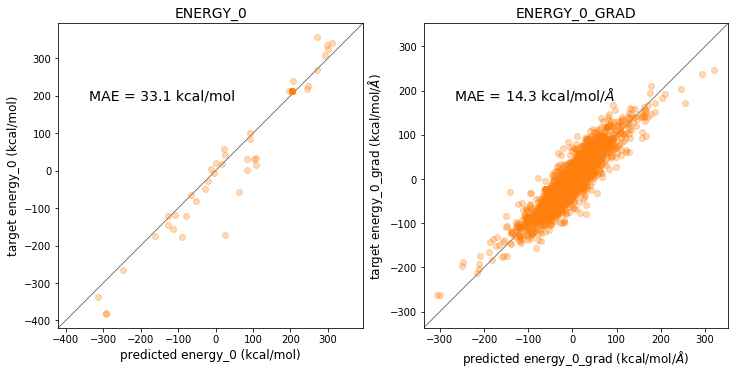

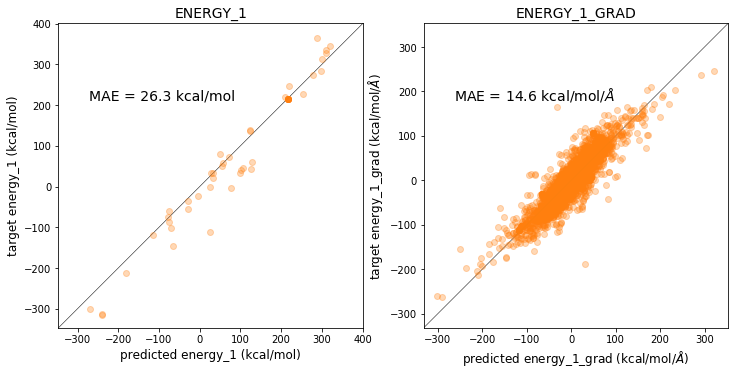

In [9]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

plot_overall(results, targets)

AuTopology is doing pretty well! Now we'll call the function `transfer_to_schnet`, which freezes the AuTopology parameters and adds the SchNet module to the output:

In [10]:
model.transfer_to_schnet()

Now we make a new trainer and train the new model, which itself contains a trained AuTopology force field and an un-trained SchNet model:

In [11]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)
    

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]



new_T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )



In [12]:
new_T.train(device=DEVICE, n_epochs=N_EPOCHS)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-18 19:31:42 |     1 |     1.000e-04 |   603.8975 |       1788.8694 |      43.3210 |           14.6474 |      38.3119 |           15.2753 |               0
2019-11-18 19:31:43 |     2 |     1.000e-04 |   595.7185 |       1778.4276 |      43.5541 |           14.6231 |      38.0881 |           15.2439 |               0
2019-11-18 19:31:44 |     3 |     1.000e-04 |   589.6712 |       1745.1418 |      42.9370 |           14.6059 |      37.1456 |           15.2172 |               0
2019-11-18 19:31:46 |     4 |     1.000e-04 |   585.8586 |       1719.7397 |      42.4563 |           14.5873 |      36.8319 |           15.1829 |               0
2019-11-18 19:31:47 |     5 |     1.000e-04 |   583.2918 |       1704.9057 |      42.2514 |           14.5603 |      36.8821 |           15.1413 |               0
2019-11-18 19:31:48 | 

2019-11-18 19:32:48 |    51 |     1.000e-04 |   315.3111 |       1061.6981 |      30.7126 |           11.7486 |      26.9065 |           12.3142 |               0
2019-11-18 19:32:49 |    52 |     1.000e-04 |   327.7579 |       1158.4845 |      35.7791 |           11.7205 |      32.7257 |           12.2908 |               0
2019-11-18 19:32:51 |    53 |     1.000e-04 |   344.3739 |       1049.4714 |      29.6739 |           11.6568 |      25.5988 |           12.2555 |               0
2019-11-18 19:32:52 |    54 |     1.000e-04 |   336.3683 |       1047.6582 |      32.9990 |           11.6295 |      31.5116 |           12.2523 |               0
2019-11-18 19:32:53 |    55 |     1.000e-04 |   336.3510 |       1081.0883 |      30.5278 |           11.5889 |      26.9076 |           12.1872 |               0
2019-11-18 19:32:55 |    56 |     1.000e-04 |   319.1741 |       1025.3735 |      28.1623 |           11.5407 |      25.2012 |           12.1421 |               0
2019-11-18 19:32:56 | 

2019-11-18 19:33:54 |   102 |     1.000e-04 |   229.6769 |        913.0901 |      26.3998 |           10.7038 |      24.0574 |           11.3111 |               0
2019-11-18 19:33:56 |   103 |     1.000e-04 |   234.7231 |        849.7099 |      22.5327 |           10.6982 |      21.1141 |           11.3226 |               0
2019-11-18 19:33:57 |   104 |     1.000e-04 |   229.1155 |        847.6589 |      25.3707 |           10.7053 |      23.8510 |           11.3578 |               0
2019-11-18 19:33:59 |   105 |     1.000e-04 |   228.0321 |        841.6066 |      22.8023 |           10.6357 |      20.7555 |           11.2793 |               0
2019-11-18 19:34:00 |   106 |     1.000e-04 |   220.0040 |        883.8767 |      24.6138 |           10.6677 |      22.1155 |           11.2943 |               0
2019-11-18 19:34:01 |   107 |     1.000e-04 |   226.8324 |        873.9560 |      23.9102 |           10.6407 |      21.3203 |           11.2717 |               0
2019-11-18 19:34:02 | 

2019-11-18 19:35:01 |   153 |     1.000e-04 |   177.4301 |        801.3070 |      21.2432 |           10.2315 |      19.7869 |           10.9241 |               0
2019-11-18 19:35:02 |   154 |     1.000e-04 |   180.0459 |        820.9626 |      22.4968 |           10.2174 |      21.2681 |           10.9126 |               0
2019-11-18 19:35:03 |   155 |     1.000e-04 |   180.5313 |        801.0783 |      21.4155 |           10.1656 |      18.9822 |           10.8724 |               0
2019-11-18 19:35:04 |   156 |     1.000e-04 |   179.7374 |        776.3627 |      20.9569 |           10.1438 |      19.9553 |           10.8616 |               0
2019-11-18 19:35:06 |   157 |     1.000e-04 |   184.8616 |        780.7052 |      25.1570 |           10.1376 |      23.8683 |           10.8571 |               0
2019-11-18 19:35:07 |   158 |     1.000e-04 |   192.1820 |        770.7477 |      25.3272 |           10.1115 |      23.8987 |           10.8302 |               0
2019-11-18 19:35:08 | 

2019-11-18 19:36:06 |   204 |     1.000e-04 |   149.9908 |        734.9977 |      20.9240 |            9.8396 |      19.7186 |           10.5644 |               0
2019-11-18 19:36:07 |   205 |     1.000e-04 |   154.5267 |        731.7474 |      21.3928 |            9.8415 |      20.4361 |           10.5665 |               0
2019-11-18 19:36:08 |   206 |     1.000e-04 |   151.5262 |        722.5912 |      17.4143 |            9.8049 |      15.7685 |           10.5225 |               0
2019-11-18 19:36:10 |   207 |     1.000e-04 |   146.7753 |        760.5432 |      20.6321 |            9.8391 |      19.4923 |           10.5319 |               0
2019-11-18 19:36:11 |   208 |     1.000e-04 |   150.4619 |        755.4967 |      19.3447 |            9.8458 |      18.5131 |           10.5438 |               0
2019-11-18 19:36:12 |   209 |     1.000e-04 |   146.9917 |        726.0824 |      18.1883 |            9.7860 |      17.2586 |           10.5150 |               0
2019-11-18 19:36:14 | 

2019-11-18 19:37:11 |   255 |     1.000e-04 |   128.8081 |        699.1260 |      17.3729 |            9.5838 |      16.9797 |           10.3337 |               0
2019-11-18 19:37:13 |   256 |     1.000e-04 |   124.4913 |        703.9267 |      16.5183 |            9.5585 |      15.1678 |           10.2917 |               0
2019-11-18 19:37:14 |   257 |     1.000e-04 |   124.6738 |        731.2234 |      18.4422 |            9.5790 |      18.1057 |           10.3125 |               0
2019-11-18 19:37:15 |   258 |     1.000e-04 |   125.2525 |        719.7728 |      17.1177 |            9.5445 |      15.8384 |           10.2870 |               0
2019-11-18 19:37:16 |   259 |     1.000e-04 |   122.9638 |        704.7954 |      17.0797 |            9.5499 |      16.5521 |           10.3103 |               0
2019-11-18 19:37:18 |   260 |     1.000e-04 |   124.5677 |        708.0609 |      19.4560 |            9.5550 |      18.9375 |           10.3327 |               0
2019-11-18 19:37:19 | 

2019-11-18 19:38:16 |   306 |     5.000e-05 |   108.2694 |        693.9996 |      15.1506 |            9.4185 |      14.3569 |           10.2153 |               0
2019-11-18 19:38:18 |   307 |     5.000e-05 |   108.0742 |        693.4869 |      15.1277 |            9.4163 |      14.3638 |           10.2134 |               0
2019-11-18 19:38:19 |   308 |     5.000e-05 |   107.8723 |        693.6289 |      15.1334 |            9.4137 |      14.3355 |           10.2109 |               0
2019-11-18 19:38:20 |   309 |     5.000e-05 |   107.6758 |        693.4187 |      15.1237 |            9.4112 |      14.3370 |           10.2090 |               0
2019-11-18 19:38:21 |   310 |     2.500e-05 |   107.4949 |        693.3830 |      15.1222 |            9.4098 |      14.3354 |           10.2079 |               0
2019-11-18 19:38:23 |   311 |     2.500e-05 |   107.3937 |        693.3201 |      15.1195 |            9.4084 |      14.3360 |           10.2066 |               0
2019-11-18 19:38:24 | 

2019-11-18 19:39:21 |   357 |     1.250e-05 |   103.6137 |        691.0400 |      15.0222 |            9.3519 |      14.1643 |           10.1614 |               0
2019-11-18 19:39:23 |   358 |     1.250e-05 |   103.5628 |        691.0124 |      15.0210 |            9.3511 |      14.1618 |           10.1608 |               0
2019-11-18 19:39:24 |   359 |     1.250e-05 |   103.5118 |        690.9838 |      15.0198 |            9.3503 |      14.1596 |           10.1602 |               0
2019-11-18 19:39:25 |   360 |     1.250e-05 |   103.4608 |        690.9554 |      15.0185 |            9.3495 |      14.1578 |           10.1596 |               0
2019-11-18 19:39:26 |   361 |     1.250e-05 |   103.4097 |        690.9303 |      15.0173 |            9.3486 |      14.1558 |           10.1590 |               0
2019-11-18 19:39:28 |   362 |     1.250e-05 |   103.3585 |        690.9055 |      15.0161 |            9.3478 |      14.1539 |           10.1584 |               0
2019-11-18 19:39:29 | 

2019-11-18 19:40:26 |   408 |     3.125e-06 |   101.9595 |        690.2186 |      14.9840 |            9.3252 |      14.1088 |           10.1418 |               0
2019-11-18 19:40:27 |   409 |     3.125e-06 |   101.9458 |        690.2102 |      14.9836 |            9.3250 |      14.1085 |           10.1416 |               0
2019-11-18 19:40:28 |   410 |     3.125e-06 |   101.9320 |        690.2011 |      14.9832 |            9.3248 |      14.1082 |           10.1414 |               0
2019-11-18 19:40:30 |   411 |     3.125e-06 |   101.9182 |        690.1931 |      14.9829 |            9.3245 |      14.1077 |           10.1412 |               0
2019-11-18 19:40:31 |   412 |     3.125e-06 |   101.9045 |        690.1860 |      14.9826 |            9.3243 |      14.1072 |           10.1411 |               0
2019-11-18 19:40:32 |   413 |     3.125e-06 |   101.8907 |        690.1788 |      14.9823 |            9.3241 |      14.1067 |           10.1409 |               0
2019-11-18 19:40:34 | 

2019-11-18 19:41:31 |   459 |     1.563e-06 |   101.4169 |        689.9499 |      14.9713 |            9.3164 |      14.0918 |           10.1351 |               0
2019-11-18 19:41:32 |   460 |     1.563e-06 |   101.4096 |        689.9463 |      14.9712 |            9.3163 |      14.0916 |           10.1350 |               0
2019-11-18 19:41:33 |   461 |     1.563e-06 |   101.4021 |        689.9426 |      14.9710 |            9.3162 |      14.0913 |           10.1349 |               0
2019-11-18 19:41:35 |   462 |     1.563e-06 |   101.3947 |        689.9390 |      14.9708 |            9.3160 |      14.0911 |           10.1348 |               0
2019-11-18 19:41:36 |   463 |     1.563e-06 |   101.3873 |        689.9354 |      14.9706 |            9.3159 |      14.0908 |           10.1347 |               0
2019-11-18 19:41:37 |   464 |     1.563e-06 |   101.3799 |        689.9314 |      14.9705 |            9.3158 |      14.0906 |           10.1346 |               0
2019-11-18 19:41:39 | 

2019-11-18 19:42:36 |   510 |     3.906e-07 |   101.2275 |        689.8580 |      14.9671 |            9.3134 |      14.0860 |           10.1328 |               0
2019-11-18 19:42:37 |   511 |     3.906e-07 |   101.2255 |        689.8575 |      14.9671 |            9.3133 |      14.0860 |           10.1328 |               0
2019-11-18 19:42:38 |   512 |     3.906e-07 |   101.2236 |        689.8564 |      14.9670 |            9.3133 |      14.0859 |           10.1327 |               0
2019-11-18 19:42:39 |   513 |     3.906e-07 |   101.2215 |        689.8556 |      14.9670 |            9.3133 |      14.0859 |           10.1327 |               0
2019-11-18 19:42:41 |   514 |     3.906e-07 |   101.2195 |        689.8544 |      14.9669 |            9.3132 |      14.0858 |           10.1327 |               0
2019-11-18 19:42:42 |   515 |     3.906e-07 |   101.2175 |        689.8534 |      14.9669 |            9.3132 |      14.0857 |           10.1327 |               0
2019-11-18 19:42:43 | 

Now we'll evaluate the results:

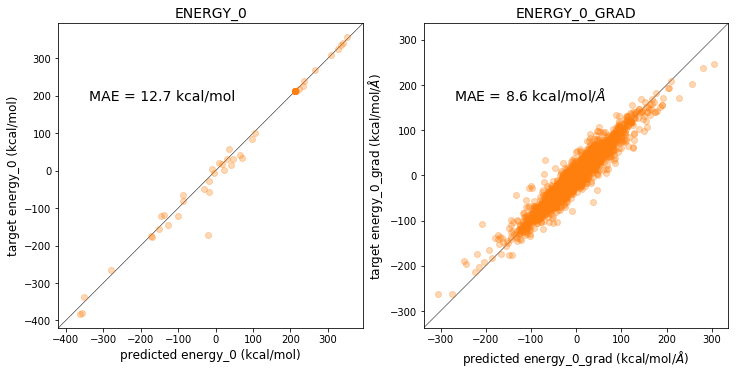

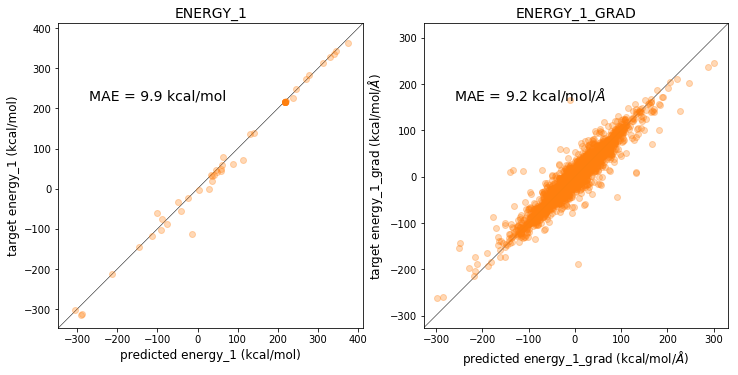

In [13]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)


plot_overall(results, targets)

## II. Comparison to regular SchNet

Now let's compare to regular SchNet

In [16]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)


    shutil.move(OUTDIR, newpath)

# create a new model and set "model_type" to "SchNet"

new_model = get_model(schnet_params, model_type="SchNet")
trainable_params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]



newest_T = Trainer(
        model_path=OUTDIR,
        model=new_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [17]:
newest_T.train(device=DEVICE, n_epochs=2*N_EPOCHS)


               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-18 19:47:00 |     1 |     1.000e-04 |  6565.3836 |      12348.4448 |     159.9731 |           35.3463 |     151.8746 |           34.9981 |               0
2019-11-18 19:47:01 |     2 |     1.000e-04 |  6364.0705 |      11935.8833 |     157.1335 |           35.3479 |     145.8234 |           35.0109 |               0
2019-11-18 19:47:01 |     3 |     1.000e-04 |  6195.6942 |      11550.0940 |     154.8076 |           35.3441 |     140.9566 |           35.0195 |               0
2019-11-18 19:47:02 |     4 |     1.000e-04 |  6067.9862 |      11229.4352 |     153.1531 |           35.3276 |     137.8982 |           35.0145 |               0
2019-11-18 19:47:03 |     5 |     1.000e-04 |  6010.1750 |      11036.4340 |     151.8023 |           35.2852 |     136.0321 |           34.9748 |               0
2019-11-18 19:47:04 | 

2019-11-18 19:47:42 |    51 |     1.000e-04 |  1329.6047 |       2609.4814 |      50.9381 |           21.7685 |      48.3009 |           21.2241 |               0
2019-11-18 19:47:43 |    52 |     1.000e-04 |  1257.3128 |       2547.5499 |      44.1543 |           22.0419 |      41.5514 |           21.3599 |               0
2019-11-18 19:47:44 |    53 |     1.000e-04 |  1175.8137 |       2504.5366 |      42.1160 |           21.9014 |      39.7834 |           21.1693 |               0
2019-11-18 19:47:44 |    54 |     1.000e-04 |  1138.4366 |       2468.7556 |      47.0369 |           21.3576 |      44.5817 |           20.7627 |               0
2019-11-18 19:47:45 |    55 |     1.000e-04 |  1230.5924 |       2645.5508 |      54.1514 |           21.1569 |      52.7564 |           20.6620 |               0
2019-11-18 19:47:46 |    56 |     1.000e-04 |  1263.6781 |       2439.0335 |      43.6244 |           21.5854 |      41.1829 |           20.9193 |               0
2019-11-18 19:47:47 | 

2019-11-18 19:48:25 |   102 |     1.000e-04 |   711.2724 |       1986.2292 |      47.7028 |           17.6947 |      50.4537 |           17.1249 |               0
2019-11-18 19:48:25 |   103 |     1.000e-04 |   772.7669 |       1567.4557 |      31.1695 |           17.4786 |      32.4431 |           17.0665 |               0
2019-11-18 19:48:26 |   104 |     1.000e-04 |   767.4968 |       2211.1399 |      56.5475 |           16.9793 |      58.0547 |           16.7559 |               0
2019-11-18 19:48:27 |   105 |     1.000e-04 |   867.3407 |       1697.3491 |      37.4512 |           17.4418 |      38.8290 |           16.9831 |               0
2019-11-18 19:48:28 |   106 |     1.000e-04 |   768.2833 |       1738.0237 |      38.8358 |           17.3172 |      41.9475 |           16.8331 |               0
2019-11-18 19:48:29 |   107 |     1.000e-04 |   694.5239 |       1857.5552 |      45.6007 |           16.9637 |      46.5723 |           16.6746 |               0
2019-11-18 19:48:30 | 

2019-11-18 19:49:07 |   153 |     1.000e-04 |   442.0335 |       1204.1430 |      24.0424 |           15.3628 |      25.2401 |           15.0667 |               0
2019-11-18 19:49:08 |   154 |     1.000e-04 |   431.2338 |       1207.0786 |      24.8637 |           15.3236 |      24.7869 |           15.0328 |               0
2019-11-18 19:49:09 |   155 |     1.000e-04 |   431.6319 |       1218.7288 |      26.0197 |           15.2940 |      26.3610 |           15.0059 |               0
2019-11-18 19:49:10 |   156 |     1.000e-04 |   431.3699 |       1201.1983 |      24.2505 |           15.2827 |      24.6304 |           14.9800 |               0
2019-11-18 19:49:11 |   157 |     1.000e-04 |   424.7285 |       1188.9233 |      24.0815 |           15.2339 |      24.5624 |           14.9412 |               0
2019-11-18 19:49:11 |   158 |     1.000e-04 |   422.2089 |       1199.0391 |      25.9762 |           15.1655 |      26.0217 |           14.8952 |               0
2019-11-18 19:49:12 | 

2019-11-18 19:49:50 |   204 |     1.000e-04 |   396.5660 |       1169.5256 |      32.6158 |           13.7748 |      33.3320 |           13.7098 |               0
2019-11-18 19:49:51 |   205 |     1.000e-04 |   461.4295 |       1288.6990 |      40.8793 |           13.9488 |      41.1596 |           13.8793 |               0
2019-11-18 19:49:52 |   206 |     1.000e-04 |   429.0473 |       1066.4255 |      25.2535 |           13.9422 |      28.6129 |           13.7182 |               0
2019-11-18 19:49:53 |   207 |     1.000e-04 |   394.9720 |       1101.1992 |      31.6902 |           14.2373 |      33.3688 |           13.8898 |               0
2019-11-18 19:49:53 |   208 |     1.000e-04 |   393.6361 |       1101.2856 |      27.6298 |           13.8209 |      28.4507 |           13.6212 |               0
2019-11-18 19:49:54 |   209 |     1.000e-04 |   406.4778 |       1228.9766 |      37.4893 |           13.8705 |      38.1054 |           13.7287 |               0
2019-11-18 19:49:55 | 

2019-11-18 19:50:33 |   255 |     1.000e-04 |   296.4248 |        958.1845 |      22.8297 |           13.0809 |      23.4788 |           12.8882 |               0
2019-11-18 19:50:34 |   256 |     1.000e-04 |   290.4251 |        924.4420 |      19.5282 |           13.1486 |      22.1586 |           12.9057 |               0
2019-11-18 19:50:34 |   257 |     1.000e-04 |   287.8229 |        913.1033 |      19.2612 |           13.1184 |      22.6028 |           12.8714 |               0
2019-11-18 19:50:35 |   258 |     1.000e-04 |   283.4914 |        923.2716 |      20.9895 |           12.9997 |      21.1361 |           12.8036 |               0
2019-11-18 19:50:36 |   259 |     1.000e-04 |   287.0920 |        962.7989 |      24.4653 |           12.9894 |      24.9249 |           12.8121 |               0
2019-11-18 19:50:37 |   260 |     1.000e-04 |   289.9530 |        927.7046 |      20.1100 |           13.0379 |      20.7673 |           12.8260 |               0
2019-11-18 19:50:38 | 

2019-11-18 19:51:15 |   306 |     1.000e-04 |   284.7661 |        891.9856 |      23.0744 |           12.5432 |      25.9040 |           12.3160 |               0
2019-11-18 19:51:16 |   307 |     1.000e-04 |   289.5875 |        865.4343 |      23.6232 |           12.4971 |      25.8279 |           12.2878 |               0
2019-11-18 19:51:17 |   308 |     1.000e-04 |   275.8834 |        949.2965 |      27.5185 |           12.3136 |      27.9230 |           12.1957 |               0
2019-11-18 19:51:17 |   309 |     1.000e-04 |   305.7386 |        972.0558 |      29.8424 |           12.4251 |      30.6760 |           12.2674 |               0
2019-11-18 19:51:18 |   310 |     1.000e-04 |   285.1471 |        909.6863 |      24.4666 |           12.5677 |      27.3919 |           12.3216 |               0
2019-11-18 19:51:19 |   311 |     1.000e-04 |   299.2893 |        874.1179 |      24.8062 |           12.5174 |      26.7433 |           12.2918 |               0
2019-11-18 19:51:20 | 

2019-11-18 19:51:57 |   357 |     1.000e-04 |   242.2846 |        821.3348 |      20.2589 |           11.9281 |      20.3731 |           11.7841 |               0
2019-11-18 19:51:58 |   358 |     1.000e-04 |   227.5568 |        834.8104 |      21.3479 |           12.0344 |      24.2970 |           11.8333 |               0
2019-11-18 19:51:59 |   359 |     1.000e-04 |   238.3304 |        787.5715 |      16.2073 |           11.9676 |      18.4895 |           11.8192 |               0
2019-11-18 19:52:00 |   360 |     1.000e-04 |   226.7189 |        878.3532 |      24.8385 |           11.8631 |      25.2906 |           11.7678 |               0
2019-11-18 19:52:01 |   361 |     1.000e-04 |   240.1047 |        811.4732 |      18.6858 |           11.9527 |      19.4639 |           11.7838 |               0
2019-11-18 19:52:01 |   362 |     1.000e-04 |   229.0792 |        826.9550 |      21.7156 |           11.9786 |      24.8168 |           11.7845 |               0
2019-11-18 19:52:02 | 

2019-11-18 19:52:39 |   408 |     1.000e-04 |   224.4020 |        918.3020 |      27.4262 |           11.5434 |      28.1240 |           11.5291 |               0
2019-11-18 19:52:40 |   409 |     1.000e-04 |   255.6217 |        796.2012 |      21.0239 |           11.5355 |      21.3083 |           11.4369 |               0
2019-11-18 19:52:41 |   410 |     1.000e-04 |   220.2279 |        863.1084 |      25.9964 |           11.6937 |      29.0755 |           11.5207 |               0
2019-11-18 19:52:42 |   411 |     1.000e-04 |   245.1392 |        759.5797 |      16.7267 |           11.5729 |      18.4208 |           11.5117 |               0
2019-11-18 19:52:43 |   412 |     1.000e-04 |   223.3381 |        916.3847 |      29.3567 |           11.4288 |      29.9658 |           11.4150 |               0
2019-11-18 19:52:44 |   413 |     1.000e-04 |   238.9199 |        783.9633 |      19.4028 |           11.6518 |      20.3980 |           11.5015 |               0
2019-11-18 19:52:44 | 

2019-11-18 19:53:22 |   459 |     1.000e-04 |   215.0201 |        752.0765 |      17.6512 |           11.2186 |      19.4409 |           11.2184 |               0
2019-11-18 19:53:22 |   460 |     1.000e-04 |   206.6392 |        859.4819 |      28.2514 |           11.1042 |      28.8877 |           11.1087 |               0
2019-11-18 19:53:23 |   461 |     1.000e-04 |   213.7452 |        763.7228 |      19.7346 |           11.2840 |      20.8507 |           11.1806 |               0
2019-11-18 19:53:24 |   462 |     1.000e-04 |   210.6714 |        766.6301 |      21.8702 |           11.2681 |      24.6398 |           11.2084 |               0
2019-11-18 19:53:25 |   463 |     1.000e-04 |   204.4326 |        806.2478 |      22.0010 |           11.1181 |      22.2673 |           11.1401 |               0
2019-11-18 19:53:26 |   464 |     1.000e-04 |   216.4846 |        810.4094 |      24.9193 |           11.1562 |      25.4934 |           11.1238 |               0
2019-11-18 19:53:26 | 

2019-11-18 19:54:04 |   510 |     1.000e-04 |   190.2708 |        740.9990 |      21.0142 |           10.9822 |      23.8995 |           10.9611 |               0
2019-11-18 19:54:05 |   511 |     1.000e-04 |   187.7897 |        762.6112 |      20.1172 |           10.8417 |      20.5258 |           10.8948 |               0
2019-11-18 19:54:05 |   512 |     1.000e-04 |   194.4055 |        783.7451 |      24.3135 |           10.8741 |      24.7903 |           10.8808 |               0
2019-11-18 19:54:06 |   513 |     1.000e-04 |   184.5699 |        749.1585 |      20.2825 |           10.9485 |      22.8703 |           10.8862 |               0
2019-11-18 19:54:07 |   514 |     1.000e-04 |   196.1821 |        711.3080 |      17.4051 |           10.9611 |      20.2195 |           10.9648 |               0
2019-11-18 19:54:08 |   515 |     1.000e-04 |   180.4519 |        804.9349 |      24.3049 |           10.7692 |      24.7811 |           10.8303 |               0
2019-11-18 19:54:09 | 

2019-11-18 19:54:46 |   561 |     1.000e-04 |   179.3053 |        754.5025 |      23.4171 |           10.6103 |      23.7547 |           10.6533 |               0
2019-11-18 19:54:47 |   562 |     1.000e-04 |   169.3248 |        720.5574 |      19.1396 |           10.6711 |      21.7075 |           10.6639 |               0
2019-11-18 19:54:48 |   563 |     1.000e-04 |   179.5878 |        692.8488 |      17.5278 |           10.6826 |      20.0870 |           10.6968 |               0
2019-11-18 19:54:48 |   564 |     1.000e-04 |   167.1911 |        763.3169 |      22.7799 |           10.5337 |      23.1271 |           10.6039 |               0
2019-11-18 19:54:49 |   565 |     1.000e-04 |   181.0736 |        731.2275 |      20.7804 |           10.5960 |      20.9838 |           10.6302 |               0
2019-11-18 19:54:50 |   566 |     1.000e-04 |   165.6635 |        727.0449 |      20.1336 |           10.6760 |      23.2330 |           10.6699 |               0
2019-11-18 19:54:51 | 

2019-11-18 19:55:28 |   612 |     1.000e-04 |   167.3447 |        687.8676 |      17.0941 |           10.3851 |      17.4774 |           10.4261 |               0
2019-11-18 19:55:29 |   613 |     1.000e-04 |   154.3314 |        704.9260 |      20.9102 |           10.4865 |      23.3720 |           10.4790 |               0
2019-11-18 19:55:30 |   614 |     1.000e-04 |   165.0833 |        670.4294 |      14.9537 |           10.3376 |      17.3643 |           10.4001 |               0
2019-11-18 19:55:31 |   615 |     1.000e-04 |   154.7671 |        756.6742 |      25.5298 |           10.3071 |      25.7047 |           10.4183 |               0
2019-11-18 19:55:32 |   616 |     1.000e-04 |   165.1426 |        684.6084 |      16.7451 |           10.3699 |      17.1778 |           10.4105 |               0
2019-11-18 19:55:33 |   617 |     1.000e-04 |   153.3008 |        701.4408 |      20.6974 |           10.4682 |      23.0957 |           10.4604 |               0
2019-11-18 19:55:33 | 

2019-11-18 19:56:11 |   663 |     1.000e-04 |   147.9779 |        710.0653 |      19.2296 |           10.1848 |      19.7282 |           10.2204 |               0
2019-11-18 19:56:12 |   664 |     1.000e-04 |   140.2642 |        673.3461 |      15.4160 |           10.2625 |      18.8248 |           10.2719 |               0
2019-11-18 19:56:13 |   665 |     1.000e-04 |   148.9440 |        669.6845 |      19.2472 |           10.1422 |      21.4979 |           10.2337 |               0
2019-11-18 19:56:13 |   666 |     1.000e-04 |   147.1108 |        655.7273 |      16.1794 |           10.1063 |      16.4130 |           10.2829 |               0
2019-11-18 19:56:14 |   667 |     1.000e-04 |   149.3937 |        756.9599 |      26.4677 |           10.0974 |      26.7414 |           10.2055 |               0
2019-11-18 19:56:15 |   668 |     1.000e-04 |   153.0443 |        699.0533 |      16.8232 |           10.2398 |      18.1240 |           10.2460 |               0
2019-11-18 19:56:16 | 

2019-11-18 19:56:53 |   714 |     1.000e-04 |   137.2172 |        650.2680 |      14.4970 |            9.9621 |      15.0055 |           10.0457 |               0
2019-11-18 19:56:54 |   715 |     1.000e-04 |   129.1968 |        661.1094 |      17.9756 |           10.0559 |      20.5301 |           10.0965 |               0
2019-11-18 19:56:55 |   716 |     1.000e-04 |   135.8990 |        634.1052 |      13.0934 |            9.9068 |      15.2251 |           10.0338 |               0
2019-11-18 19:56:56 |   717 |     1.000e-04 |   127.7072 |        690.2765 |      21.7015 |            9.8964 |      21.6029 |           10.0548 |               0
2019-11-18 19:56:56 |   718 |     1.000e-04 |   134.1746 |        654.9971 |      15.0118 |            9.9293 |      15.4432 |           10.0237 |               0
2019-11-18 19:56:57 |   719 |     1.000e-04 |   125.0411 |        654.6399 |      16.1315 |           10.0330 |      19.2907 |           10.0760 |               0
2019-11-18 19:56:58 | 

2019-11-18 19:57:35 |   765 |     1.000e-04 |   142.7910 |        660.5061 |      14.6218 |           10.0049 |      16.9472 |           10.0272 |               0
2019-11-18 19:57:36 |   766 |     1.000e-04 |   145.0147 |        700.9956 |      24.9887 |            9.8628 |      26.6216 |            9.9764 |               0
2019-11-18 19:57:37 |   767 |     1.000e-04 |   155.8211 |        623.0704 |      14.8569 |            9.7975 |      16.3418 |           10.0418 |               0
2019-11-18 19:57:38 |   768 |     1.000e-04 |   147.7724 |        780.9256 |      31.2497 |            9.7885 |      31.0416 |            9.9791 |               0
2019-11-18 19:57:39 |   769 |     1.000e-04 |   159.8065 |        693.2069 |      19.3251 |            9.8904 |      20.1768 |            9.9458 |               0
2019-11-18 19:57:39 |   770 |     1.000e-04 |   139.3984 |        701.3130 |      23.4224 |           10.0265 |      25.1747 |           10.0488 |               0
2019-11-18 19:57:40 | 

2019-11-18 19:58:17 |   816 |     5.000e-05 |   104.9900 |        627.4974 |      12.1807 |            9.6154 |      13.6976 |            9.7850 |               0
2019-11-18 19:58:18 |   817 |     2.500e-05 |   104.8817 |        627.6629 |      12.2466 |            9.6137 |      13.6742 |            9.7839 |               0
2019-11-18 19:58:19 |   818 |     2.500e-05 |   104.8463 |        628.3593 |      12.4710 |            9.6115 |      13.5976 |            9.7824 |               0
2019-11-18 19:58:20 |   819 |     2.500e-05 |   104.7865 |        627.4677 |      12.1712 |            9.6119 |      13.7022 |            9.7823 |               0
2019-11-18 19:58:21 |   820 |     2.500e-05 |   104.7456 |        628.0009 |      12.3432 |            9.6100 |      13.6448 |            9.7809 |               0
2019-11-18 19:58:22 |   821 |     2.500e-05 |   104.7048 |        628.0848 |      12.3660 |            9.6088 |      13.6385 |            9.7800 |               0
2019-11-18 19:58:22 | 

2019-11-18 19:59:00 |   867 |     1.250e-05 |   103.0658 |        627.3767 |      12.3090 |            9.5672 |      13.6611 |            9.7497 |               0
2019-11-18 19:59:00 |   868 |     1.250e-05 |   103.0430 |        627.3658 |      12.3088 |            9.5666 |      13.6610 |            9.7493 |               0
2019-11-18 19:59:01 |   869 |     1.250e-05 |   103.0201 |        627.3549 |      12.3086 |            9.5660 |      13.6610 |            9.7489 |               0
2019-11-18 19:59:02 |   870 |     1.250e-05 |   102.9972 |        627.3439 |      12.3085 |            9.5654 |      13.6609 |            9.7484 |               0
2019-11-18 19:59:03 |   871 |     1.250e-05 |   102.9743 |        627.3327 |      12.3082 |            9.5649 |      13.6608 |            9.7480 |               0
2019-11-18 19:59:04 |   872 |     1.250e-05 |   102.9514 |        627.3213 |      12.3081 |            9.5643 |      13.6608 |            9.7476 |               0
2019-11-18 19:59:05 | 

2019-11-18 19:59:42 |   918 |     3.125e-06 |   102.3781 |        626.9999 |      12.3047 |            9.5500 |      13.6574 |            9.7373 |               0
2019-11-18 19:59:42 |   919 |     3.125e-06 |   102.3721 |        626.9959 |      12.3047 |            9.5498 |      13.6573 |            9.7371 |               0
2019-11-18 19:59:43 |   920 |     3.125e-06 |   102.3660 |        626.9918 |      12.3047 |            9.5497 |      13.6573 |            9.7370 |               0
2019-11-18 19:59:44 |   921 |     3.125e-06 |   102.3599 |        626.9879 |      12.3047 |            9.5495 |      13.6572 |            9.7369 |               0
2019-11-18 19:59:45 |   922 |     3.125e-06 |   102.3538 |        626.9841 |      12.3046 |            9.5494 |      13.6572 |            9.7368 |               0
2019-11-18 19:59:46 |   923 |     3.125e-06 |   102.3477 |        626.9803 |      12.3046 |            9.5492 |      13.6572 |            9.7367 |               0
2019-11-18 19:59:47 | 

2019-11-18 20:00:24 |   969 |     1.563e-06 |   102.1472 |        626.8556 |      12.3026 |            9.5442 |      13.6560 |            9.7330 |               0
2019-11-18 20:00:25 |   970 |     1.563e-06 |   102.1440 |        626.8534 |      12.3025 |            9.5441 |      13.6559 |            9.7329 |               0
2019-11-18 20:00:25 |   971 |     1.563e-06 |   102.1407 |        626.8513 |      12.3025 |            9.5440 |      13.6559 |            9.7329 |               0
2019-11-18 20:00:26 |   972 |     7.813e-07 |   102.1376 |        626.8505 |      12.3025 |            9.5440 |      13.6559 |            9.7328 |               0
2019-11-18 20:00:27 |   973 |     7.813e-07 |   102.1360 |        626.8495 |      12.3024 |            9.5439 |      13.6559 |            9.7328 |               0
2019-11-18 20:00:28 |   974 |     7.813e-07 |   102.1344 |        626.8485 |      12.3024 |            9.5439 |      13.6559 |            9.7328 |               0
2019-11-18 20:00:29 | 

2019-11-18 20:01:06 |  1020 |     3.906e-07 |   102.0720 |        626.8104 |      12.3019 |            9.5424 |      13.6553 |            9.7317 |               0
2019-11-18 20:01:07 |  1021 |     3.906e-07 |   102.0712 |        626.8100 |      12.3019 |            9.5423 |      13.6553 |            9.7316 |               0
2019-11-18 20:01:08 |  1022 |     3.906e-07 |   102.0703 |        626.8094 |      12.3018 |            9.5423 |      13.6553 |            9.7316 |               0
2019-11-18 20:01:08 |  1023 |     3.906e-07 |   102.0695 |        626.8089 |      12.3018 |            9.5423 |      13.6553 |            9.7316 |               0
2019-11-18 20:01:09 |  1024 |     3.906e-07 |   102.0686 |        626.8083 |      12.3018 |            9.5423 |      13.6553 |            9.7316 |               0
2019-11-18 20:01:10 |  1025 |     3.906e-07 |   102.0678 |        626.8079 |      12.3018 |            9.5423 |      13.6553 |            9.7316 |               0
2019-11-18 20:01:11 | 

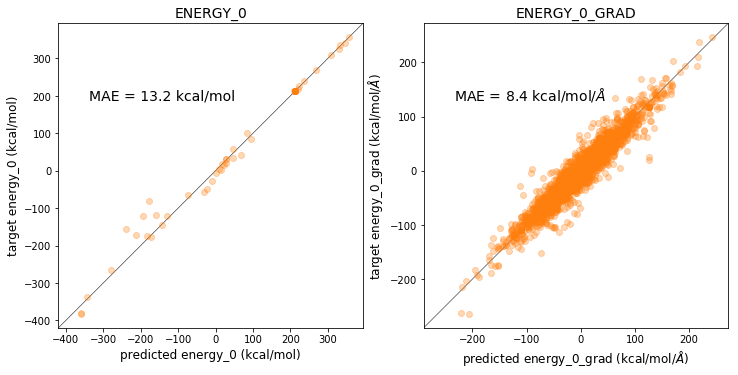

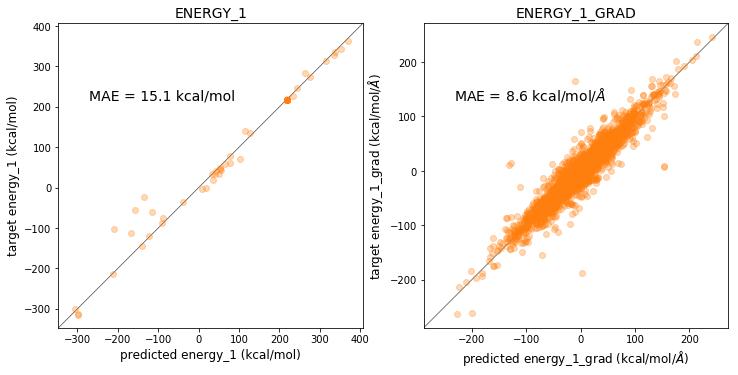

In [18]:
new_results, new_targets, new_val_loss = evaluate(new_model, test_loader, loss_fn, device=DEVICE)

plot_overall(new_results, new_targets)

The AuTopology + SchNet results are quite comparable to the SchNet results. This is great news, because it means we can get the same accuracy but with much of the answer coming from well-behaved functional forms for the energy. SchNet + AuTopology will therefore keep the molecule together during an MD run, even if there's a new geometry that hasn't been seen before. This means that the combination of SchNet + AuTopology should be more stable in MD runs than regular SchNet.

# III. Non-trainable AuTopology

Lastly, we can compare to AuTopology + SchNet, where the AuTopology parameters can't be learned. To do so we set `trainable_prior` to False. 

We also change `bond_terms` to `harmonic`, because there is a baseline spring constant to which learned parameters are added. That means that even if we don't learn any parameters, we'd still get a spring constant that keeps the molecule together. The `morse` option, on the other hand, doesn't have such as base-line spring constant, so it wouldn't help us!

In [19]:
last_params = copy.deepcopy(params)
last_params["autopology_params"]["trainble_prior"] = False
last_params["autopology_params"]["bond_terms"] = ["harmonic"]

last_model = get_model(last_params, model_type="SchNetAuTopology", add_autopology=True, add_schnet=True)



In [22]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)


    shutil.move(OUTDIR, newpath)


trainable_params = filter(lambda p: p.requires_grad, last_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

last_T = Trainer(
        model_path=OUTDIR,
        model=last_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [23]:
last_T.train(device=DEVICE, n_epochs=2*N_EPOCHS)


               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-18 20:02:21 |     1 |     1.000e-04 | 15440.6602 |      27064.5511 |     263.2329 |           38.4109 |     224.9804 |           37.1169 |               0
2019-11-18 20:02:23 |     2 |     1.000e-04 | 11255.0226 |      18903.6239 |     209.3779 |           38.5521 |     180.7481 |           37.5522 |               0
2019-11-18 20:02:24 |     3 |     1.000e-04 |  8699.5892 |      15796.9385 |     188.7325 |           38.5979 |     164.7597 |           37.9281 |               0
2019-11-18 20:02:26 |     4 |     1.000e-04 |  7616.1053 |      13160.8423 |     169.3469 |           38.6532 |     150.2949 |           38.2915 |               0
2019-11-18 20:02:27 |     5 |     1.000e-04 |  7443.3688 |      12955.1551 |     161.5892 |           38.8541 |     141.7719 |           38.7885 |               0
2019-11-18 20:02:29 | 

2019-11-18 20:03:37 |    51 |     1.000e-04 |  1398.4553 |       2952.6970 |      41.9179 |           22.2852 |      40.0055 |           21.9074 |               0
2019-11-18 20:03:38 |    52 |     1.000e-04 |  1322.2250 |       3438.2530 |      51.2366 |           22.2624 |      54.1011 |           21.7965 |               0
2019-11-18 20:03:40 |    53 |     1.000e-04 |  1336.2620 |       2997.8244 |      41.6414 |           22.0095 |      43.1076 |           21.5630 |               0
2019-11-18 20:03:41 |    54 |     1.000e-04 |  1254.0208 |       2835.9008 |      40.0969 |           21.7850 |      40.4584 |           21.3572 |               0
2019-11-18 20:03:43 |    55 |     1.000e-04 |  1228.2045 |       3026.3547 |      42.8189 |           21.6666 |      44.2140 |           21.2159 |               0
2019-11-18 20:03:44 |    56 |     1.000e-04 |  1235.2733 |       2965.7367 |      41.1445 |           21.4806 |      43.1109 |           21.0538 |               0
2019-11-18 20:03:46 | 

2019-11-18 20:04:52 |   102 |     1.000e-04 |   870.0448 |       2382.6557 |      45.4652 |           17.3593 |      51.3169 |           16.9274 |               0
2019-11-18 20:04:54 |   103 |     1.000e-04 |   836.8293 |       2002.9816 |      27.1513 |           17.1478 |      32.6180 |           16.8014 |               0
2019-11-18 20:04:55 |   104 |     1.000e-04 |   787.2429 |       1933.5771 |      34.2236 |           17.0474 |      36.0522 |           16.7453 |               0
2019-11-18 20:04:57 |   105 |     1.000e-04 |   779.3224 |       1910.6763 |      28.7856 |           17.0564 |      32.3494 |           16.7195 |               0
2019-11-18 20:04:59 |   106 |     1.000e-04 |   749.3949 |       2088.6828 |      33.7664 |           17.1420 |      37.6541 |           16.7283 |               0
2019-11-18 20:05:00 |   107 |     1.000e-04 |   785.0453 |       2371.1978 |      45.4921 |           17.1486 |      51.1661 |           16.6982 |               0
2019-11-18 20:05:01 | 

2019-11-18 20:06:08 |   153 |     1.000e-04 |   673.0899 |       1782.2226 |      33.7802 |           15.2087 |      40.3076 |           14.8480 |               0
2019-11-18 20:06:09 |   154 |     1.000e-04 |   602.9468 |       1495.7421 |      30.7420 |           15.0908 |      33.1317 |           14.7929 |               0
2019-11-18 20:06:11 |   155 |     1.000e-04 |   599.8773 |       1500.6895 |      25.2458 |           15.0574 |      29.1785 |           14.7610 |               0
2019-11-18 20:06:12 |   156 |     1.000e-04 |   559.8019 |       1899.0559 |      36.9110 |           15.1161 |      38.2946 |           14.7861 |               0
2019-11-18 20:06:14 |   157 |     1.000e-04 |   618.7723 |       1675.2313 |      28.3623 |           15.0276 |      33.3413 |           14.7150 |               0
2019-11-18 20:06:15 |   158 |     1.000e-04 |   570.7939 |       1477.1358 |      29.8207 |           14.9342 |      30.9884 |           14.6596 |               0
2019-11-18 20:06:17 | 

2019-11-18 20:07:24 |   204 |     1.000e-04 |   452.0108 |       1264.4586 |      22.1868 |           13.9109 |      26.6795 |           13.6534 |               0
2019-11-18 20:07:25 |   205 |     1.000e-04 |   441.0098 |       1263.2468 |      21.8863 |           13.8822 |      26.1465 |           13.6326 |               0
2019-11-18 20:07:27 |   206 |     1.000e-04 |   428.2775 |       1419.2069 |      24.3562 |           13.9138 |      28.1020 |           13.6454 |               0
2019-11-18 20:07:28 |   207 |     1.000e-04 |   445.4013 |       1440.5752 |      26.3615 |           13.8987 |      31.5359 |           13.6335 |               0
2019-11-18 20:07:30 |   208 |     1.000e-04 |   442.8572 |       1271.4556 |      20.7594 |           13.8355 |      25.4153 |           13.5974 |               0
2019-11-18 20:07:31 |   209 |     1.000e-04 |   430.3552 |       1248.3123 |      22.6600 |           13.7890 |      26.8780 |           13.5626 |               0
2019-11-18 20:07:33 | 

2019-11-18 20:08:38 |   255 |     1.000e-04 |   374.5164 |       1099.1349 |      23.2730 |           13.0260 |      27.1484 |           12.8439 |               0
2019-11-18 20:08:40 |   256 |     1.000e-04 |   372.7104 |       1139.1464 |      19.6138 |           13.0467 |      24.5587 |           12.8452 |               0
2019-11-18 20:08:41 |   257 |     1.000e-04 |   360.7671 |       1290.7124 |      26.3511 |           13.1021 |      31.6056 |           12.8637 |               0
2019-11-18 20:08:43 |   258 |     1.000e-04 |   383.2758 |       1230.3417 |      25.3339 |           13.0831 |      30.6786 |           12.8624 |               0
2019-11-18 20:08:44 |   259 |     1.000e-04 |   371.0639 |       1095.5695 |      19.8033 |           12.9812 |      24.3234 |           12.7935 |               0
2019-11-18 20:08:46 |   260 |     1.000e-04 |   361.2927 |       1111.2111 |      20.7709 |           12.9668 |      26.3664 |           12.7818 |               0
2019-11-18 20:08:47 | 

2019-11-18 20:09:55 |   306 |     1.000e-04 |   315.6956 |        988.6999 |      20.4986 |           12.3660 |      25.5832 |           12.2016 |               0
2019-11-18 20:09:57 |   307 |     1.000e-04 |   310.8311 |       1069.0732 |      18.3707 |           12.4151 |      23.1009 |           12.2151 |               0
2019-11-18 20:09:58 |   308 |     1.000e-04 |   311.6927 |       1139.6343 |      25.3973 |           12.4343 |      30.5391 |           12.2341 |               0
2019-11-18 20:10:00 |   309 |     1.000e-04 |   320.3273 |       1005.4494 |      17.9551 |           12.3705 |      22.4599 |           12.1931 |               0
2019-11-18 20:10:01 |   310 |     1.000e-04 |   307.0954 |        982.4038 |      19.8926 |           12.3131 |      25.1123 |           12.1484 |               0
2019-11-18 20:10:03 |   311 |     1.000e-04 |   306.8274 |       1011.3448 |      17.0319 |           12.3400 |      21.8431 |           12.1519 |               0
2019-11-18 20:10:04 | 

2019-11-18 20:11:10 |   357 |     1.000e-04 |   282.4024 |        898.6617 |      23.0623 |           11.7595 |      27.3801 |           11.6187 |               0
2019-11-18 20:11:11 |   358 |     1.000e-04 |   289.0327 |        946.0212 |      17.2091 |           11.8028 |      22.1076 |           11.6395 |               0
2019-11-18 20:11:13 |   359 |     1.000e-04 |   274.0382 |       1084.6862 |      27.0011 |           11.8442 |      31.8560 |           11.6634 |               0
2019-11-18 20:11:14 |   360 |     1.000e-04 |   290.9964 |        931.0328 |      18.9146 |           11.8100 |      23.1271 |           11.6556 |               0
2019-11-18 20:11:16 |   361 |     1.000e-04 |   274.4517 |        887.8818 |      20.7669 |           11.7340 |      25.8558 |           11.5912 |               0
2019-11-18 20:11:17 |   362 |     1.000e-04 |   279.1516 |        921.8034 |      16.9189 |           11.7542 |      21.8128 |           11.5962 |               0
2019-11-18 20:11:19 | 

2019-11-18 20:12:24 |   408 |     1.000e-04 |   260.7272 |        799.7988 |      18.5833 |           11.2928 |      22.3808 |           11.1814 |               0
2019-11-18 20:12:26 |   409 |     1.000e-04 |   262.1918 |        836.4452 |      22.0396 |           11.2551 |      26.5815 |           11.1377 |               0
2019-11-18 20:12:27 |   410 |     1.000e-04 |   252.1361 |        982.7570 |      22.1145 |           11.2858 |      25.3125 |           11.1547 |               0
2019-11-18 20:12:29 |   411 |     1.000e-04 |   260.5628 |        966.5384 |      25.2874 |           11.3030 |      30.2481 |           11.1711 |               0
2019-11-18 20:12:30 |   412 |     1.000e-04 |   253.7377 |        797.6496 |      19.3134 |           11.2363 |      23.4065 |           11.1252 |               0
2019-11-18 20:12:32 |   413 |     1.000e-04 |   258.5082 |        835.1516 |      20.8954 |           11.2220 |      26.0914 |           11.1084 |               0
2019-11-18 20:12:33 | 

2019-11-18 20:13:38 |   459 |     1.000e-04 |   237.1002 |       1000.1671 |      30.4596 |           10.7561 |      34.9639 |           10.6853 |               0
2019-11-18 20:13:40 |   460 |     1.000e-04 |   248.0126 |        754.2516 |      16.6363 |           10.7603 |      20.6725 |           10.6942 |               0
2019-11-18 20:13:41 |   461 |     1.000e-04 |   235.3183 |        778.9704 |      23.7662 |           10.7581 |      27.2570 |           10.6906 |               0
2019-11-18 20:13:43 |   462 |     1.000e-04 |   231.3857 |        906.4366 |      20.8401 |           10.8189 |      23.8505 |           10.7190 |               0
2019-11-18 20:13:44 |   463 |     1.000e-04 |   240.3370 |        940.8050 |      27.9396 |           10.8594 |      32.9147 |           10.7426 |               0
2019-11-18 20:13:46 |   464 |     1.000e-04 |   232.8024 |        733.1919 |      18.8061 |           10.8147 |      22.4966 |           10.7417 |               0
2019-11-18 20:13:47 | 

2019-11-18 20:14:52 |   510 |     1.000e-04 |   194.0587 |        726.7460 |      15.2071 |           10.3889 |      20.3709 |           10.4054 |               0
2019-11-18 20:14:54 |   511 |     1.000e-04 |   211.7151 |        754.6652 |      26.0341 |           10.3849 |      29.7760 |           10.3654 |               0
2019-11-18 20:14:55 |   512 |     1.000e-04 |   237.4486 |        722.6182 |      24.1000 |           10.4752 |      27.8340 |           10.3987 |               0
2019-11-18 20:14:57 |   513 |     1.000e-04 |   219.2154 |        753.3137 |      17.3885 |           10.5943 |      21.3363 |           10.4971 |               0
2019-11-18 20:14:58 |   514 |     1.000e-04 |   243.7675 |       1184.0491 |      43.1903 |           10.5374 |      48.0167 |           10.4591 |               0
2019-11-18 20:14:59 |   515 |     1.000e-04 |   315.3375 |       1106.2612 |      39.2441 |           10.3864 |      43.6427 |           10.4003 |               0
2019-11-18 20:15:01 | 

2019-11-18 20:16:06 |   561 |     1.000e-04 |   154.7599 |        694.6851 |      13.4391 |           10.0992 |      17.4172 |           10.0880 |               0
2019-11-18 20:16:07 |   562 |     1.000e-04 |   153.9816 |        670.2788 |      12.3537 |           10.0893 |      16.9476 |           10.0857 |               0
2019-11-18 20:16:09 |   563 |     1.000e-04 |   154.3034 |        658.7724 |      13.3445 |           10.0866 |      18.2479 |           10.0790 |               0
2019-11-18 20:16:10 |   564 |     1.000e-04 |   154.7367 |        661.4053 |      12.3886 |           10.0874 |      17.2895 |           10.0701 |               0
2019-11-18 20:16:12 |   565 |     1.000e-04 |   152.5155 |        685.1164 |      13.4258 |           10.1004 |      17.3819 |           10.0789 |               0
2019-11-18 20:16:13 |   566 |     1.000e-04 |   153.3337 |        712.9745 |      15.6186 |           10.0937 |      19.8077 |           10.0819 |               0
2019-11-18 20:16:15 | 

2019-11-18 20:17:19 |   612 |     1.000e-04 |   145.5956 |        648.9629 |      12.5967 |            9.7876 |      16.3442 |            9.8256 |               0
2019-11-18 20:17:21 |   613 |     1.000e-04 |   140.4491 |        633.5446 |      13.5373 |            9.7417 |      18.3986 |            9.7889 |               0
2019-11-18 20:17:22 |   614 |     1.000e-04 |   142.3549 |        628.8517 |      12.2421 |            9.7560 |      17.0788 |            9.7899 |               0
2019-11-18 20:17:24 |   615 |     1.000e-04 |   137.3872 |        648.1422 |      12.9002 |            9.7953 |      16.5434 |            9.8234 |               0
2019-11-18 20:17:25 |   616 |     1.000e-04 |   137.5055 |        662.4249 |      13.7374 |            9.7756 |      17.5996 |            9.8096 |               0
2019-11-18 20:17:27 |   617 |     1.000e-04 |   136.7369 |        645.9276 |      11.9029 |            9.7437 |      15.7153 |            9.7887 |               0
2019-11-18 20:17:28 | 

2019-11-18 20:18:33 |   663 |     1.000e-04 |   131.6175 |        672.7579 |      17.6988 |            9.5332 |      21.5918 |            9.6019 |               0
2019-11-18 20:18:35 |   664 |     1.000e-04 |   137.2463 |        638.4498 |      14.6626 |            9.5338 |      18.3248 |            9.6138 |               0
2019-11-18 20:18:36 |   665 |     1.000e-04 |   130.0587 |        605.2585 |      14.0891 |            9.4611 |      18.4385 |            9.5485 |               0
2019-11-18 20:18:37 |   666 |     1.000e-04 |   134.3130 |        609.4434 |      13.3260 |            9.4564 |      18.1444 |            9.5375 |               0
2019-11-18 20:18:39 |   667 |     1.000e-04 |   126.8217 |        628.4509 |      13.2917 |            9.5110 |      16.8910 |            9.5823 |               0
2019-11-18 20:18:40 |   668 |     1.000e-04 |   126.5911 |        641.4454 |      14.7069 |            9.5182 |      18.3954 |            9.5962 |               0
2019-11-18 20:18:42 | 

2019-11-18 20:19:47 |   714 |     2.500e-05 |   113.3301 |        604.3079 |      10.9558 |            9.3663 |      14.5438 |            9.4877 |               0
2019-11-18 20:19:49 |   715 |     2.500e-05 |   113.2569 |        604.2273 |      10.9482 |            9.3649 |      14.5397 |            9.4868 |               0
2019-11-18 20:19:50 |   716 |     2.500e-05 |   113.1842 |        604.1845 |      10.9503 |            9.3635 |      14.5354 |            9.4859 |               0
2019-11-18 20:19:52 |   717 |     2.500e-05 |   113.1108 |        604.0853 |      10.9486 |            9.3621 |      14.5332 |            9.4850 |               0
2019-11-18 20:19:53 |   718 |     2.500e-05 |   113.0376 |        604.0045 |      10.9443 |            9.3606 |      14.5277 |            9.4841 |               0
2019-11-18 20:19:54 |   719 |     2.500e-05 |   112.9640 |        603.9322 |      10.9410 |            9.3592 |      14.5216 |            9.4833 |               0
2019-11-18 20:19:56 | 

2019-11-18 20:21:00 |   765 |     1.250e-05 |   110.5225 |        601.1059 |      10.8684 |            9.3121 |      14.3787 |            9.4530 |               0
2019-11-18 20:21:02 |   766 |     1.250e-05 |   110.4846 |        601.0585 |      10.8671 |            9.3113 |      14.3764 |            9.4525 |               0
2019-11-18 20:21:03 |   767 |     1.250e-05 |   110.4467 |        601.0114 |      10.8661 |            9.3106 |      14.3740 |            9.4520 |               0
2019-11-18 20:21:05 |   768 |     1.250e-05 |   110.4087 |        600.9645 |      10.8650 |            9.3098 |      14.3717 |            9.4515 |               0
2019-11-18 20:21:06 |   769 |     1.250e-05 |   110.3707 |        600.9172 |      10.8639 |            9.3090 |      14.3694 |            9.4511 |               0
2019-11-18 20:21:08 |   770 |     6.250e-06 |   110.3331 |        600.9100 |      10.8658 |            9.3087 |      14.3678 |            9.4508 |               0
2019-11-18 20:21:09 | 

2019-11-18 20:22:13 |   816 |     3.125e-06 |   109.5825 |        600.0517 |      10.8492 |            9.2938 |      14.3250 |            9.4415 |               0
2019-11-18 20:22:15 |   817 |     3.125e-06 |   109.5723 |        600.0403 |      10.8489 |            9.2936 |      14.3244 |            9.4414 |               0
2019-11-18 20:22:16 |   818 |     3.125e-06 |   109.5622 |        600.0280 |      10.8486 |            9.2934 |      14.3237 |            9.4412 |               0
2019-11-18 20:22:18 |   819 |     3.125e-06 |   109.5521 |        600.0166 |      10.8483 |            9.2931 |      14.3231 |            9.4411 |               0
2019-11-18 20:22:19 |   820 |     3.125e-06 |   109.5419 |        600.0045 |      10.8479 |            9.2929 |      14.3225 |            9.4410 |               0
2019-11-18 20:22:21 |   821 |     3.125e-06 |   109.5318 |        599.9930 |      10.8477 |            9.2927 |      14.3219 |            9.4408 |               0
2019-11-18 20:22:22 | 

2019-11-18 20:23:27 |   867 |     7.813e-07 |   109.2455 |        599.6761 |      10.8419 |            9.2871 |      14.3054 |            9.4374 |               0
2019-11-18 20:23:28 |   868 |     7.813e-07 |   109.2428 |        599.6728 |      10.8419 |            9.2871 |      14.3053 |            9.4374 |               0
2019-11-18 20:23:30 |   869 |     7.813e-07 |   109.2401 |        599.6696 |      10.8419 |            9.2870 |      14.3051 |            9.4373 |               0
2019-11-18 20:23:31 |   870 |     7.813e-07 |   109.2374 |        599.6662 |      10.8418 |            9.2870 |      14.3050 |            9.4373 |               0
2019-11-18 20:23:33 |   871 |     7.813e-07 |   109.2347 |        599.6633 |      10.8418 |            9.2869 |      14.3048 |            9.4373 |               0
2019-11-18 20:23:34 |   872 |     7.813e-07 |   109.2320 |        599.6597 |      10.8417 |            9.2869 |      14.3047 |            9.4372 |               0
2019-11-18 20:23:36 | 

2019-11-18 20:24:40 |   918 |     3.906e-07 |   109.1375 |        599.5508 |      10.8398 |            9.2850 |      14.2992 |            9.4361 |               0
2019-11-18 20:24:42 |   919 |     3.906e-07 |   109.1361 |        599.5490 |      10.8398 |            9.2850 |      14.2991 |            9.4360 |               0
2019-11-18 20:24:43 |   920 |     3.906e-07 |   109.1346 |        599.5473 |      10.8397 |            9.2850 |      14.2990 |            9.4360 |               0
2019-11-18 20:24:45 |   921 |     3.906e-07 |   109.1332 |        599.5457 |      10.8397 |            9.2849 |      14.2989 |            9.4360 |               0
2019-11-18 20:24:46 |   922 |     3.906e-07 |   109.1318 |        599.5440 |      10.8397 |            9.2849 |      14.2988 |            9.4360 |               0
2019-11-18 20:24:48 |   923 |     3.906e-07 |   109.1303 |        599.5420 |      10.8396 |            9.2849 |      14.2987 |            9.4360 |               0
2019-11-18 20:24:49 | 

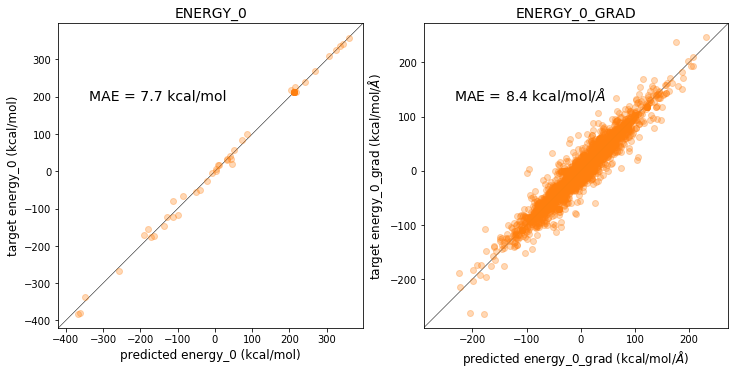

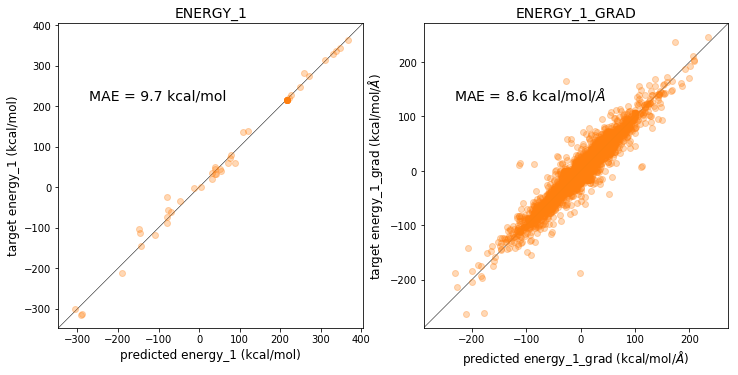

In [24]:
last_results, last_targets, last_vall_loss = evaluate(last_model, test_loader, loss_fn, device=DEVICE)

plot_overall(last_results, last_targets)